In [17]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings('ignore')
data = pd.read_csv('./input/insurance.csv')

### Data example

In [18]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Encode string features

In [19]:
# sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates())
data.sex = le.transform(data.sex)

# smoker
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)

# region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)


data.head()

# columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [5])], remainder='passthrough')
# dataset = columnTransformer.fit_transform(data)


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


### Data distributions

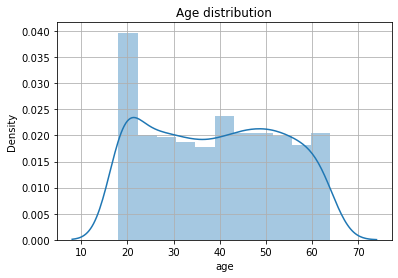

In [20]:
pl.figure()
pl.title('Age distribution')
pl.grid()
ax = sns.distplot(data['age'])

### Smokers by sex

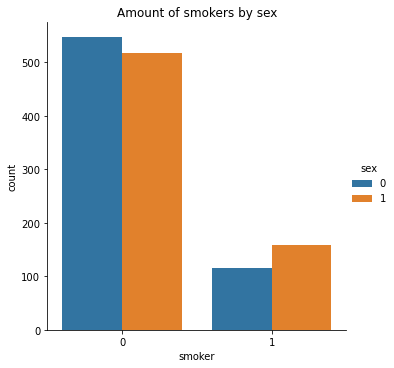

In [21]:
sns.catplot(x='smoker', kind='count', hue='sex', data=data).set(title='Amount of smokers by sex')

### Distribution of charges according to age: smokers vs non-smokers

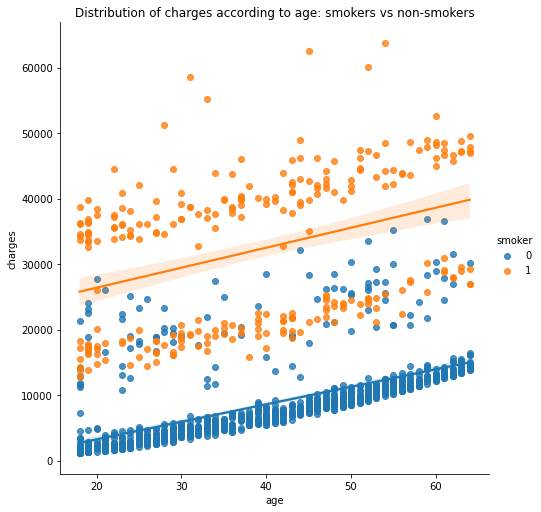

In [22]:
sns.lmplot(x='age', y='charges', hue='smoker', data=data, size=7).set(title='Distribution of charges according to age: smokers vs non-smokers')

### BMI Distributions

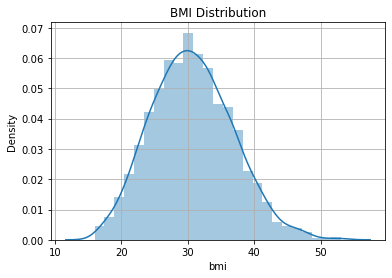

In [23]:
pl.figure()
pl.grid()
ax = sns.distplot(data['bmi']).set(title='BMI Distribution')

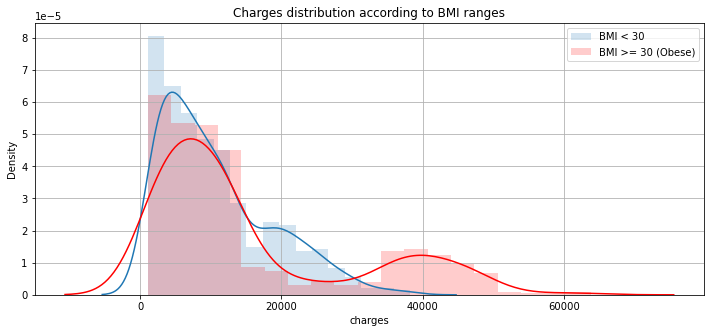

In [24]:
alpha = .2
pl.figure(figsize=(12,5))
pl.title("Charges distribution according to BMI ranges")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], hist_kws={'alpha': alpha}, label='BMI < 30')
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color='red', hist_kws={'alpha': alpha}, label='BMI >= 30 (Obese)')
pl.legend()
pl.grid()

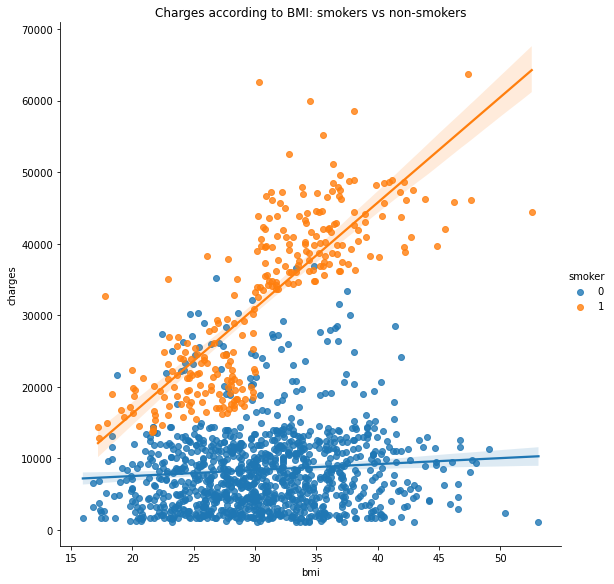

In [25]:
sns.lmplot(x='bmi', y='charges', hue='smoker', data=data, size=8).set(title='Charges according to BMI: smokers vs non-smokers')

### Correlations

In [26]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

From these results, we can infer that smoking is the feature most correlated to the insurance charges, followed by age, BMI, number of children, sex and, finally, region.

We must take into consideration that there are may be correlations between different features.

<AxesSubplot:>

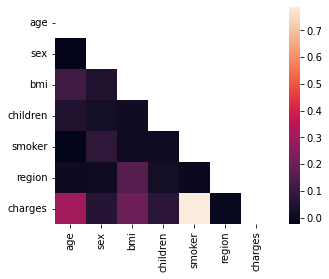

In [27]:
corr = data.corr()
mask = np.zeros_like(corr, dtype='bool')
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, square=True, mask=mask)

This graph restates what we previously investigated. Additionally, it exposes correlations. Most notably, individuals from the Southeast tend to have higher BMI. This is to be expected, as most Southeastern states have a high prevalence of obesity, according to the CDC. Due to this fact, residing in the Southeast does not likely imply higher charges. They are probably related to the higher average BMI in comparison to the remaining regions, as this is the third feature most correlated to the charges.

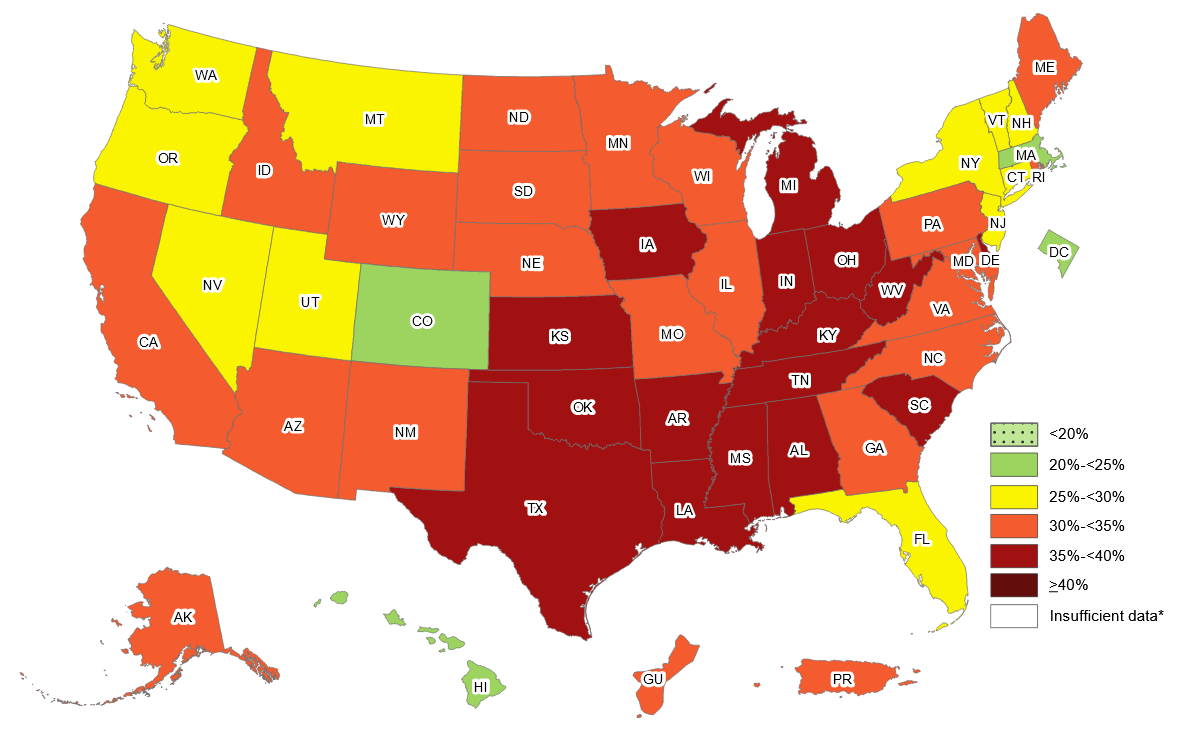


### Comparison of charges between non-smokers and smokers

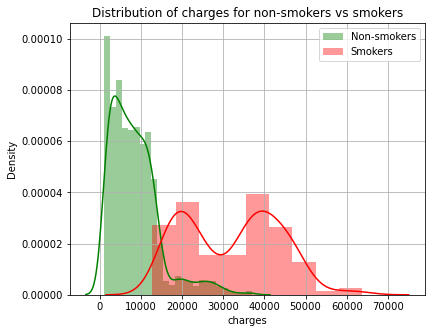

In [28]:
f = pl.figure(figsize=(14, 5))

ax = f.add_subplot(1, 2, 1)
ax.set_title('Distribution of charges for non-smokers vs smokers')
sns.distplot(data[(data.smoker == False)]['charges'], color='green', ax=ax, label='Non-smokers')
sns.distplot(data[(data.smoker == True)]['charges'], color='red', ax=ax, label='Smokers')
ax.grid()
ax.legend()

In [33]:
def avg(lst):
    return sum(lst) / len(lst)

CV = 10

x = data.drop(['charges'], axis = 1)
y = data.charges

# We tested dropping the region feature from x as well. The results were:
# Linear Regression: 0.7201882009816053, 0.7398315857552282
# Random Forest Regression: 0.7949847217864517, 0.8365885225391667
# Ridge Regression: 0.7202342710701529, 0.7403405422886756
# Lasso Regression: 0.7201913686682861, 0.739834575265828
# Polynomial Linear Regression: 0.8182861781068448, 0.850648448897197
# They were marginally worse than the results obtained without dropping it.

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Standardization had no effects, and thus was not applied. The same was verified for normalization.
# Standardization
# scalar = StandardScaler()
# scalar.fit(x_train)
# x_train = scalar.transform(x_train)
# x_test = scalar.transform(x_test)

lr = LinearRegression()
rfr = RandomForestRegressor(random_state=0)
rr = Ridge(alpha=.5)
lasso = Lasso(alpha=.2, random_state=0)

cv_scores_lr_training = cross_val_score(lr, x_train, y_train, cv=CV)
cv_scores_rfr_training = cross_val_score(rfr, x_train, y_train, cv=CV)
cv_scores_rr_training = cross_val_score(rr, x_train, y_train, cv=CV)
cv_scores_lasso_training = cross_val_score(lasso, x_train, y_train, cv=CV)

cv_scores_lr_testing = cross_val_score(lr, x_test, y_test, cv=CV)
cv_scores_rfr_testing = cross_val_score(rfr, x_test, y_test, cv=CV)
cv_scores_rr_testing = cross_val_score(rr, x_test, y_test, cv=CV)
cv_scores_lasso_testing = cross_val_score(lasso, x_test, y_test, cv=CV)

X = data.drop(['charges'], axis=1)
Y = data.charges

quad = PolynomialFeatures(degree=2)
x_quad = quad.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(x_quad, Y, random_state=0)

plr = LinearRegression()
cv_scores_plr_training = cross_val_score(plr, X_train, Y_train, cv=CV)
cv_scores_plr_testing = cross_val_score(plr, X_test, Y_test, cv=CV)



print(f'''CV Scores
Linear Regression: {avg(cv_scores_lr_training)}, {avg(cv_scores_lr_testing)}
Random Forest Regression: {avg(cv_scores_rfr_training)}, {avg(cv_scores_rfr_testing)}
Ridge Regression: {avg(cv_scores_rr_training)}, {avg(cv_scores_rr_testing)}
Lasso Regression: {avg(cv_scores_lasso_training)}, {avg(cv_scores_lasso_testing)}
Polynomial Linear Regression: {avg(cv_scores_plr_training)}, {avg(cv_scores_plr_testing)}
''')

CV Scores
Linear Regression: 0.720654342339283, 0.7411838605425343
Random Forest Regression: 0.804861471130503, 0.8378626496683854
Ridge Regression: 0.7207035078023001, 0.7417176777713276
Lasso Regression: 0.7206578020547676, 0.7411866189408994
Polynomial Linear Regression: 0.8199572509304016, 0.8437632950590779




Polynomial Regression
MSE train data: 24080212.111, MSE test data: 18163476.892
R2 train data: 0.831, R2 test data: 0.885

Random Forest Regression
MSE train data: 3744526.416, MSE test data: 20337176.372
R2 train data: 0.974, R2 test data: 0.871

Linear Regression
MSE train data: 38050102.806, MSE test data: 32073628.560
R2 train data: 0.734, R2 test data: 0.796

Ridge Regression
MSE train data: 38050962.285, MSE test data: 32095866.222
R2 train data: 0.734, R2 test data: 0.796

Lasso Regression
MSE train data: 38050103.243, MSE test data: 32073855.023
R2 train data: 0.734, R2 test data: 0.796


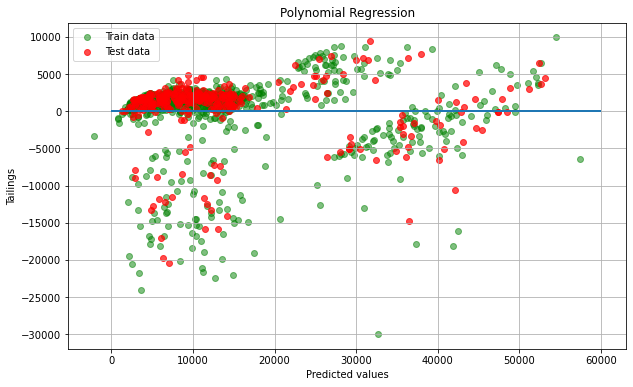

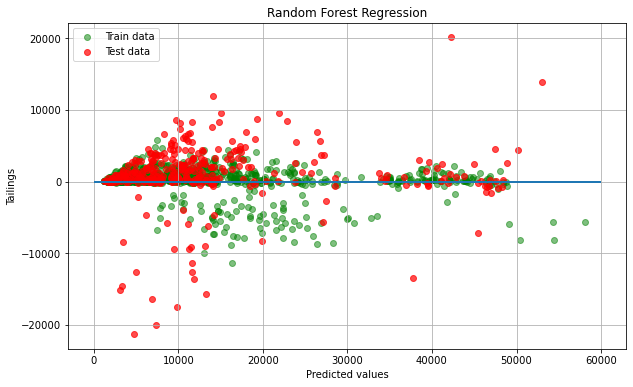

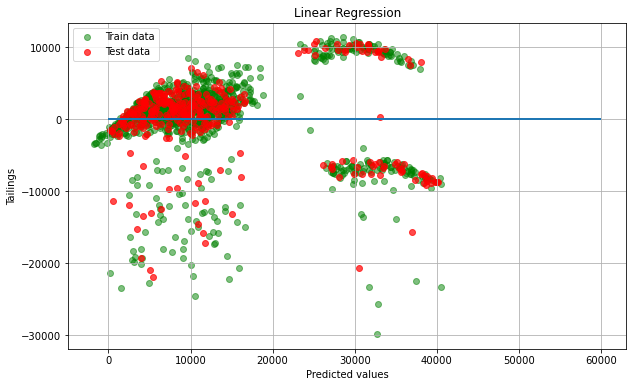

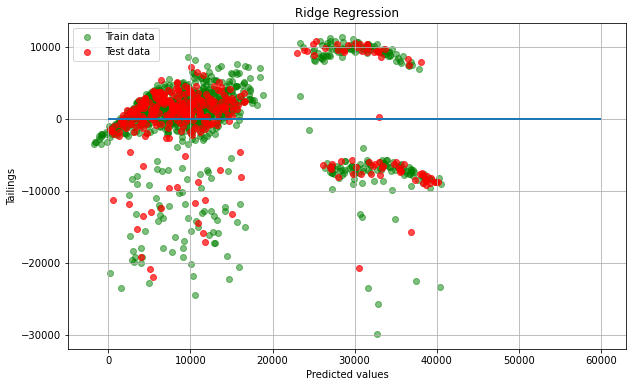

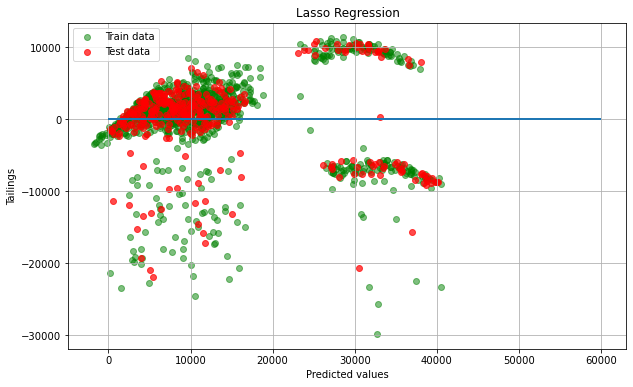

In [30]:
plr.fit(X_train, Y_train)
Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print('\nPolynomial Regression')
print(f'MSE train data: {metrics.mean_squared_error(Y_train, Y_train_pred):.3f}, MSE test data: {metrics.mean_squared_error(Y_test, Y_test_pred):.3f}')
print(f'R2 train data: {metrics.r2_score(Y_train, Y_train_pred):.3f}, R2 test data: {metrics.r2_score(Y_test, Y_test_pred):.3f}')

rfr.fit(x_train, y_train)
forest_train_pred = rfr.predict(x_train)
forest_test_pred = rfr.predict(x_test)

print('\nRandom Forest Regression')
print(f'MSE train data: {metrics.mean_squared_error(y_train, forest_train_pred):.3f}, MSE test data: {metrics.mean_squared_error(y_test, forest_test_pred):.3f}')
print(f'R2 train data: {metrics.r2_score(y_train, forest_train_pred):.3f}, R2 test data: {metrics.r2_score(y_test, forest_test_pred):.3f}')

lr.fit(x_train, y_train)
lr_train_pred = lr.predict(x_train)
lr_test_pred = lr.predict(x_test)

print('\nLinear Regression')
print(f'MSE train data: {metrics.mean_squared_error(y_train, lr_train_pred):.3f}, MSE test data: {metrics.mean_squared_error(y_test, lr_test_pred):.3f}')
print(f'R2 train data: {metrics.r2_score(y_train, lr_train_pred):.3f}, R2 test data: {metrics.r2_score(y_test, lr_test_pred):.3f}')

rr.fit(x_train, y_train)
rr_train_pred = rr.predict(x_train)
rr_test_pred = rr.predict(x_test)

print('\nRidge Regression')
print(f'MSE train data: {metrics.mean_squared_error(y_train, rr_train_pred):.3f}, MSE test data: {metrics.mean_squared_error(y_test, rr_test_pred):.3f}')
print(f'R2 train data: {metrics.r2_score(y_train, rr_train_pred):.3f}, R2 test data: {metrics.r2_score(y_test, rr_test_pred):.3f}')

lasso.fit(x_train, y_train)
lasso_train_pred = lasso.predict(x_train)
lasso_test_pred = lasso.predict(x_test)

print('\nLasso Regression')
print(f'MSE train data: {metrics.mean_squared_error(y_train, lasso_train_pred):.3f}, MSE test data: {metrics.mean_squared_error(y_test, lasso_test_pred):.3f}')
print(f'R2 train data: {metrics.r2_score(y_train, lasso_train_pred):.3f}, R2 test data: {metrics.r2_score(y_test, lasso_test_pred):.3f}')

pl.figure(figsize=(10, 6))
pl.scatter(Y_train_pred, Y_train_pred - Y_train, c='green', alpha=.5, label='Train data')
pl.scatter(Y_test_pred, Y_test_pred - Y_test, c='red', alpha=.7, label='Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.title('Polynomial Regression')
pl.legend(loc='upper left')
pl.hlines(y=0, xmin=0, xmax=60000, lw=2)
pl.grid()
pl.show()

pl.figure(figsize=(10, 6))
pl.scatter(forest_train_pred, forest_train_pred - y_train, c='green', alpha=.5, label='Train data')
pl.scatter(forest_test_pred, forest_test_pred - y_test, c='red', alpha=.7, label='Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.title('Random Forest Regression')
pl.hlines(y=0, xmin=0, xmax=60000, lw=2)
pl.grid()
pl.show()

pl.figure(figsize=(10, 6))
pl.scatter(lr_train_pred, lr_train_pred - y_train, c='green', alpha=.5, label='Train data')
pl.scatter(lr_test_pred, lr_test_pred - y_test, c='red', alpha=.7, label='Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.title('Linear Regression')
pl.legend(loc = 'upper left')
pl.hlines(y=0, xmin=0, xmax=60000, lw=2)
pl.grid()
pl.show()

pl.figure(figsize=(10, 6))
pl.scatter(rr_train_pred, rr_train_pred - y_train, c='green', alpha=.5, label='Train data')
pl.scatter(rr_test_pred, rr_test_pred - y_test, c='red', alpha=.7, label='Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.title('Ridge Regression')
pl.legend(loc = 'upper left')
pl.hlines(y=0, xmin=0, xmax=60000, lw=2)
pl.grid()
pl.show()

pl.figure(figsize=(10, 6))
pl.scatter(lasso_train_pred, lasso_train_pred - y_train, c='green', alpha=.5, label='Train data')
pl.scatter(lasso_test_pred, lasso_test_pred - y_test, c='red', alpha=.7, label='Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.title('Lasso Regression')
pl.legend(loc = 'upper left')
pl.hlines(y=0, xmin=0, xmax=60000, lw=2)
pl.grid()
pl.show()


<BarContainer object of 6 artists>

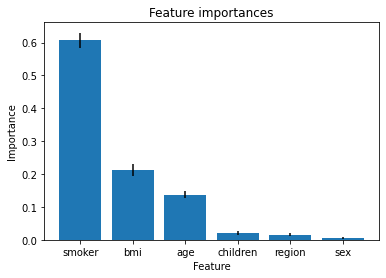

In [31]:
# Feature Importances

importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
importance_list = [variables[indices[f]] for f in range(x.shape[1])]

pl.figure()
pl.title('Feature importances')
pl.xlabel('Feature')
pl.ylabel('Importance')
pl.bar(importance_list, importances[indices], yerr=std[indices])